<a href="https://colab.research.google.com/github/jianrong1995/zikaClassification/blob/master/randomForestClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/drive')

csv_folder = '/content/drive/My Drive/Machine Learning/csv/'
model_persistence = '/content/drive/My Drive/Machine Learning/model/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##### Import statements

In [0]:
import os
import copy
import csv
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
from imblearn.over_sampling import SMOTE
from collections import defaultdict, Counter
from datetime import datetime, date
from tabulate import tabulate
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn import model_selection

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


##### Helper Methods

In [0]:
# method to do grid search
def parameterSweeping(classifier, param):
    gridSearcher = GridSearchCV(estimator = classifier,
                            param_grid = param, 
                            cv = 3, n_jobs = -1, refit=True)
    return gridSearcher

#method to plot ROC
def plotROC(groundTruth, prediction):
    fpr, tpr, threshold = metrics.roc_curve(groundTruth, prediction)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.05, 1])
    plt.ylim([-0.05, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
#method to create feature importance plot  
def featureImportancePlot(fittedModel, headers):
    feature_imp = pd.Series(fittedModel.feature_importances_,index = headers).sort_values(ascending = False)
    sns.barplot(x = feature_imp, y = feature_imp.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.legend()
    plt.show()
    print(feature_imp)

#eda method for histogram and scatterplot
def histogramPlot(data):
    sns.distplot(data)

def scatterPlot(x, y):
    sns.jointplot(x = "x", y = "y")

# Preparing Data for Classification
Run codeblock once is sufficient!

In [0]:
#this code chunk read the colombia_scaled_with_density csv and manupilate date such that it is changed to seconds since epoch time,
#some columns that are not needed are also dropped

colombia = pd.read_csv(csv_folder + "colombia_scaled_with_density.csv")
colombia['datetime']= pd.to_datetime(colombia['date_y'], yearfirst=True)
colombia['intDate'] = 0

for index, row in colombia.iterrows():
    thisDate = colombia.loc[index,'datetime']
    colombia.loc[index, 'intDate'] = int(thisDate.timestamp())

colombia.sort_values(by=['province','intDate'], inplace=True)
colombia = colombia.drop(['date_y','confirmed','cumulative','datetime'], axis=1)
colombia = colombia[['province', 'new_temp', 'new_dp', 'precipitation', 'wind', 'density', 'intDate', 'confirmed_bool']]



#The code below creates another csv file of the manupilated datafile
## colombia.to_csv(csv_folder + "colombiaClassificationML.csv")

# Random Forest National

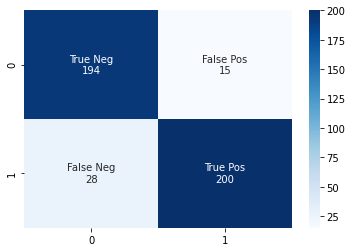

In [0]:
#creates a copy of data for national model
colombiaNat = copy.deepcopy(colombia)                 
colombiaNat.drop(columns=['province'], inplace=True)  
featuresNat = colombiaNat.iloc[:,:6]
classTypeNat = colombiaNat.iloc[:,6]

# suppresses warning and conducts SMOTE resampling for minority class
warnings.filterwarnings("ignore")
sm = SMOTE(sampling_strategy='minority', random_state=7)
oversampled_X, oversampled_y = sm.fit_sample(featuresNat, classTypeNat)

# train-test split, 20% to be left out for test data
X_train, X_test, y_train, y_test = train_test_split(oversampled_X, oversampled_y, test_size = 0.20, random_state = 5)

# initiate classifier and do a exhaustive search for best performance
rfNat = RandomForestClassifier(random_state = 5)
paramGrid = {
    'n_estimators': [5,10,15],
    'max_features': ['sqrt','log2', None],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [10,20,25,30]
}
rfNat = parameterSweeping(rfNat,paramGrid)
rfNat.fit(X_train,y_train)

#extract best performing parameters and use it
this = RandomForestClassifier(**rfNat.best_params_,verbose=0, random_state = 5)
this.fit(X_train, y_train)
y_pred = this.predict(X_test)

#plot confusion matrix using seaborn
cm = confusion_matrix(y_test, y_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(labels,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

Testing Score: 0.9016018306636155


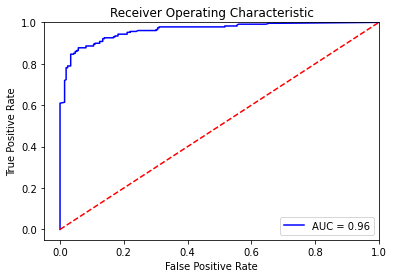

In [0]:
# find probability of each test example for plotting ROC
y_proba = this.predict_proba(X_test)
y_proba  =y_proba[:,1]
print("Testing Score: " + str(accuracy_score(y_test, y_pred)))
plotROC(y_test, y_proba)        #plot ROC

In [0]:
f1 = f1_score(y_test, y_pred)
print(f1)

0.9029345372460496


In [0]:
#display best parameters
print(rfNat.best_params_)

{'max_depth': None, 'max_features': None, 'min_samples_split': 10, 'n_estimators': 15}


No handles with labels found to put in legend.


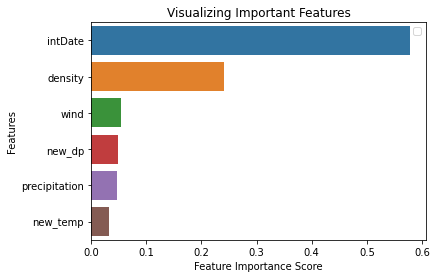

intDate          0.578105
density          0.240447
wind             0.054181
new_dp           0.048040
precipitation    0.047606
new_temp         0.031622
dtype: float64


In [0]:
featureImportancePlot(this,featuresNat.columns)

##### Export National Model

In [0]:
#export national model using python pickle, objective is to allow easy invocation without retraining
with open(model_persistence + 'randomForestNational.pkl', 'wb') as fid:
    pkl.dump(rfNat, fid)

# Random Forest Local

In [0]:
#creates a copy of data for local model
colombiaLocal = copy.deepcopy(colombia)
shellDictionary = defaultdict(list)

for index, row in colombiaLocal.iterrows():
    province = row[0]
    otherData = row[1:]
    shellDictionary[province].append(otherData)

#drop guaviare as it is sparse
shellDictionary.pop("Guaviare")

#intiate a variable such that final avergae accuracy can be computed
RFaccuracyLocalOverall = 0

#Iterate through each key and get the items in each key to do randomforest on
for province in shellDictionary:
    thisProvData = shellDictionary[province]
    provDF = pd.DataFrame(thisProvData)
    features = provDF.iloc[:,:6]
    classType = provDF.iloc[:,6]

#initiate rd classifier and do exhaustive search for each province
    rfLoc = RandomForestClassifier(random_state= 5)
    paramGrid = {
        'n_estimators': [5,10],
        'max_features': ['sqrt','log2', None],
        'max_depth': [None, 5, 10],
        'min_samples_split': [10,20]
    }
    rfLoc = parameterSweeping(rfLoc,paramGrid)
    print("\n" + province + "\n")
    rfLoc.fit(features,classType)

#fit the best parameters
    eachModel = RandomForestClassifier(**rfLoc.best_params_,verbose=0)

#perform stratifiedkfold validation, with 3 splits
    skfold = StratifiedKFold(n_splits=3, random_state=100)
    results_skfold = model_selection.cross_val_score(eachModel, features, classType, cv=skfold)
    print("Accuracy: %.2f%%" % (results_skfold.mean()*100.0))
    RFaccuracyLocalOverall += results_skfold.mean()

#export each model using python pickle model persistence
    provincepkl = "localRF" + str(province) + ".pkl"
    with open(model_persistence + provincepkl, 'wb') as fid:
        pkl.dump(eachModel, fid)

print(RFaccuracyLocalOverall/len(shellDictionary))


Amazonas

Accuracy: 92.16%

Antioquia

Accuracy: 90.07%

Arauca

Accuracy: 95.83%

Atlantico

Accuracy: 77.70%

Barranquilla

Accuracy: 94.00%

Bolivar

Accuracy: 69.73%

Boyaca

Accuracy: 97.92%

Caldas

Accuracy: 97.92%

Caqueta

Accuracy: 75.86%

Cartagena

Accuracy: 72.06%

Casanare

Accuracy: 65.69%

Cauca

Accuracy: 100.00%

Cesar

Accuracy: 90.07%

Choco

Accuracy: 90.20%

Cordoba

Accuracy: 92.03%

Cundinamarca

Accuracy: 94.00%

Guainia

Accuracy: 89.83%

Guajira

Accuracy: 97.92%

Huila

Accuracy: 96.08%

Magdalena

Accuracy: 67.65%

Meta

Accuracy: 59.44%

Narino

Accuracy: 97.92%

Norte_Santander

Accuracy: 73.16%

Putumayo

Accuracy: 94.00%

Quindio

Accuracy: 82.11%

Risaralda

Accuracy: 97.92%

San_Andres

Accuracy: 69.36%

Santander

Accuracy: 63.48%

Sucre

Accuracy: 63.60%

Tolima

Accuracy: 96.08%

Valle_Del_Cauca

Accuracy: 88.11%

Vichada

Accuracy: 96.08%
0.852481617647059


50
